This notebooks compares dendritic attenuation results obtained with three different methods:

1. NEURON simulation (i.e., what we consider the "ground truth").
1. Impedance tree (i.e., the method implemented in ``nodes.py`` and ``trees.py``).
1. The cable equation (i.e., the theoretical results that are valid in case of an unbranched piece of dendrite of infinite length).

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if '..' not in sys.path:
    sys.path = ['..'] + sys.path

from neuroutils.trees import SWCImpedanceTree

from neuron import h
h.load_file('stdrun.hoc')
h.load_file('stdlib.hoc')
h.celsius = 34

#### The parameters

In [2]:
cm   =     1.  # [uF/cm2] membrane capacitance
Ra   =   100.  # [Ohm cm] cytoplasmic resistivity
Rm   = 15000.  # [Ohm cm2] membrane resistance
El   =   -65.  # [mV] passive reversal potential
diam =     5.  # [um] (constant) diameter of the cable

#### The membrane time constant

In [3]:
taum = Rm*cm*1e-3   # [ms]
print('Membrane time constant: {:.2f} ms.'.format(taum))

Membrane time constant: 15.00 ms.


#### The length constant λ

In [4]:
length_const = np.sqrt((diam*1e-4*Rm)/(4*Ra)) * 1e4
print('Length constant: {:.3f} um.'.format(length_const))

Length constant: 1369.306 um.


Here we choose the length of the cable to be equal to a certain multiple of λ: the higher this number, the more closely the numerical solution will match the theoretical one. Either way, the values obtained with the impedance tree should match the NEURON simulation.

In [5]:
L = 4*length_const
print('Length of the cable: {:.3f} um.'.format(L))

Length of the cable: 5477.226 um.


Here we generate the points that make up the morphology and save them in an SWC file:

In [6]:
N_pts_per_lambda = 100
N_pts = int(np.ceil(L / length_const * N_pts_per_lambda))
print('The morphology contains {} points.'.format(N_pts))
X = np.zeros((N_pts, 7))
X[:,0] = np.arange(N_pts) + 1
X[:,1] = 4
X[:,2] = np.linspace(0, L, N_pts)
spatial_f = 1/length_const
X[:,3] = 100*np.sin(2*np.pi*spatial_f*X[:,2])
X[:,4] = 100*np.sin(2*np.pi*X[:,2]/L)
X[:,5] = diam + 9/10*diam*np.cos(2*np.pi*spatial_f*X[:,2])
# X[:,5] = np.linspace(diam, 1, N_pts)
X[:,6] = X[:,0] - 1
# root node
X[0,-1] = -1
swc_file = 'morpho.swc'
np.savetxt(swc_file, X, fmt='%g')

The morphology contains 400 points.


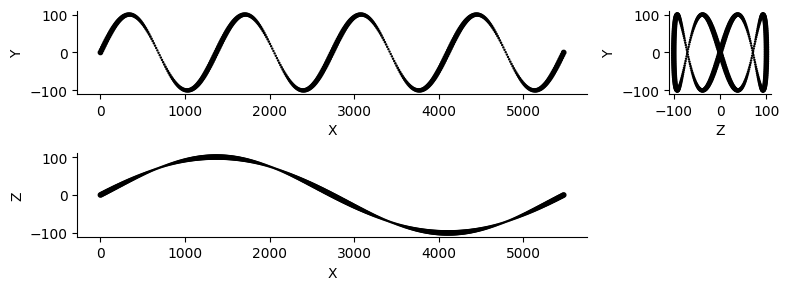

In [7]:
x,y,z = X[:,2],X[:,3],X[:,4]
ratio = max(0.2, (z.max()-z.min()) / (x.max()-x.min()))
fig,ax = plt.subplots(2, 2, figsize=(8,3),
                      width_ratios=(1, ratio),
                      height_ratios=(1, (z.max()-z.min()) / (y.max()-y.min())))
ax[0,0].scatter(x, y, s=X[:,5], c='k')
ax[0,0].set_xlabel('X')
ax[0,0].set_ylabel('Y')
ax[1,0].scatter(x, z, s=X[:,5], c='k')
ax[1,0].set_xlabel('X')
ax[1,0].set_ylabel('Z')
ax[0,1].scatter(z, y, s=X[:,5], c='k')
ax[0,1].set_xlabel('Z')
ax[0,1].set_ylabel('Y')
plt.axis('equal')
ax[1,1].axis('off')
sns.despine()
fig.tight_layout()

### Instantiate the section

In [8]:
dend = h.Section(name='dend')
dend.cm = cm
dend.Ra = Ra

xvec = h.Vector(X[:,2])
yvec = h.Vector(X[:,3])
zvec = h.Vector(X[:,4])
dvec = h.Vector(X[:,5])
h.pt3dadd(xvec, yvec, zvec, dvec, sec=dend)

dend.insert('pas')
dend.g_pas = 1/Rm
dend.e_pas = El
# setting the number of segments using the d_lambda rule
# for more information, see https://neuron.yale.edu/neuron/static/docs/d_lambda/d_lambda.html
dend.nseg = int((L/(0.1*h.lambda_f(100, sec=dend))+0.9)/2)*2 + 1
print('The dend is {:g} um long and is subdivided into {} segments.'.\
      format(dend.L, dend.nseg))

The dend is 5772.09 um long and is subdivided into 117 segments.


In [9]:
before, after = 100, 100
stim_x = 0
stim_x = 3/4
# stim_x = 0.5
stim = h.IClamp(dend(stim_x))
stim.delay = before
stim.dur = 500
stim.amp = 10 * L / length_const * 1e-3
print('Stimulus amplitude: {:g} pA.'.format(stim.amp*1e3))

Stimulus amplitude: 40 pA.


In [10]:
rec = {'t': h.Vector()}
rec['t'].record(h._ref_t)
for seg in dend:
    key = 'V-{:.3f}'.format(seg.x)
    rec[key] = h.Vector()
    rec[key].record(seg._ref_v)

In [11]:
h.cvode_active(1)
h.tstop = before + after + stim.dur
h.v_init = El
h.run();

In [12]:
root_point = max(2, int(N_pts*stim_x)+1)
tree = SWCImpedanceTree(swc_file, cm, Rm, Ra, root_point=root_point)
tree.compute_impedances(F=0)
tree.compute_attenuations()
tree.compute_distances()
A = np.array([np.abs(node.A_from_root) for node in tree])
## path distance
# dst_from_root = np.array([node.distance*(-1 if node.x < tree.root.x else 1) for node in tree])
## distance on the x-axis
dst_from_root = np.array([node.x-tree.root.x for node in tree])

Get the simulation results:

In [13]:
time = np.array(rec['t'])
V = np.array([np.array(rec[f'V-{seg.x:.3f}']) for seg in dend])
before_stim = np.where(time < stim.delay)[0][-1]
V0 = V[:,before_stim]
V1 = V.max(axis=1)
# the numerically computed voltage deflection
DeltaV = V1 - V0
# all the segment centers, in the range [0,1]
seg_x = np.array([seg.x for seg in dend])
# convert to units of length constant, relative to the location
# where the stimulus was applied
X = (seg_x - stim_x) * L / length_const

#### Theoretical values

In [14]:
# maximum deflection (i.e., where the stimulus was applied)
DeltaV_max_theory = Rm*stim.amp/(2*np.pi*diam*length_const)*100 # [mV]
# exponential decay of the deflection
DeltaV_theory = DeltaV_max_theory * np.exp(-np.abs(X))

Plot the results:

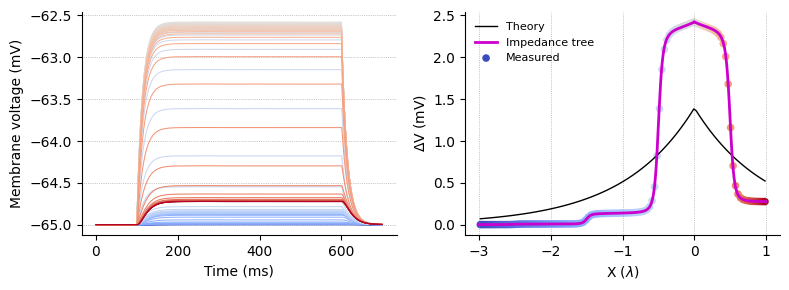

In [15]:
idx, = np.where(X<0)
jdx, = np.where(X>=0)
N_c = max(idx.size, jdx.size)
c = np.concatenate([np.linspace(0, N_c, idx.size, endpoint=False, dtype=int),
                    np.linspace(0, N_c, jdx.size, endpoint=False, dtype=int) + N_c])

cmap_name = 'coolwarm'
cmap = plt.get_cmap(cmap_name, c.max())
fig,ax = plt.subplots(1, 2, figsize=(8,3))
for i,v in enumerate(V):
    ax[0].plot(time, v, color=cmap(c[i]), lw=0.75)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Membrane voltage (mV)')
ax[0].grid(which='major', axis='y', lw=0.5, ls=':', color=[.6,.6,.6])

col = [.8,0,.8]
ax[1].plot(X, DeltaV_theory, 'k', lw=1, label='Theory')
idx,jdx = dst_from_root<0, dst_from_root>=0
ax[1].plot(dst_from_root[idx]/length_const, DeltaV.max()/A[idx], color=col, lw=2, label='Impedance tree')
ax[1].plot(dst_from_root[jdx]/length_const, DeltaV.max()/A[jdx], color=col, lw=2)
ax[1].scatter(X, DeltaV, s=30, c=c, cmap=cmap_name, alpha=1,
              linewidth=0, label='Measured', edgecolor='w')
ax[1].legend(loc='best', frameon=False, fontsize=8)
ax[1].set_xlabel('X $(\lambda)$')
ax[1].set_ylabel(r'$\Delta$V (mV)')
ax[1].grid(which='major', axis='x', lw=0.5, ls=':', color=[.6,.6,.6])
sns.despine()
fig.tight_layout()